Add google disk

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


To make sure Colab uses GPU you can run

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

Mounted at /content/gdrive


Make sure that the current GPU memory utilization is 0

In [97]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 6.6 GB  | Proc size: 23.5 GB
GPU RAM Free: 757MB | Used: 15523MB | Util  95% | Total 16280MB


If Util not 0% use kill

In [0]:
!kill -9 -1

Import libraries

In [2]:
import numpy as np
from keras import applications, Sequential, Model, optimizers, models
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, History
from keras.layers import Flatten, Dense
from keras.utils import to_categorical
from tqdm import tqdm
import os
import h5py
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


Variables with train and test directories. 
Some constant variables.

In [0]:
trainInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/train/"
testInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/test/"
validationInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/val/"
size = 199
epochs = 3
fileName = "/content/gdrive/My Drive/pneumonia/images.h5"

In [0]:
def extractData(directory):
    labels = []
    images = []

    for nextDirectory in os.listdir(directory):
        if not nextDirectory.startswith("."):
            if nextDirectory in "NORMAL":
                label = 0
            elif nextDirectory in "PNEUMONIA":
                label = 1
            else:
                label = 2

            currentDirectory = directory + nextDirectory
            if not currentDirectory.startswith("."):
                for files in tqdm(os.listdir(currentDirectory)):
                    if files.endswith('.jpg') or files.endswith('.jpeg'):
                        imagePath = currentDirectory + "/" + files
                        img = Image.open(imagePath)
                        img = img.resize((size, size)).convert("RGB")
                        data = np.array(img.getdata())
                        img = 2 * (data.reshape((img.size[0], img.size[1], 3)).astype(np.float32) / 255) - 1
                        images.append(img)
                        labels.append(label)

    labels = np.asarray(labels)

    if directory == trainInput:
        out = h5py.File(fileName, "a")
        out.create_dataset("imagesTrain", data=images)
        out.create_dataset("labelsTrain", data=labels)
        out.close()
    elif directory == testInput:
        out = h5py.File(fileName, "a")
        out.create_dataset("imagesTest", data=images)
        out.create_dataset("labelsTest", data=labels)
        out.close()
    elif directory == validationInput:
        out = h5py.File(fileName, "a")
        out.create_dataset("imagesValidation", data=images)
        out.create_dataset("labelsValidation", data=labels)
        out.close()
    else:
        pass

In [0]:
extractData(trainInput)
extractData(testInput)
extractData(validationInput)

100%|██████████| 9/9 [00:00<00:00, 25.17it/s]


Get the images and labels

In [0]:
x = h5py.File(fileName, "r")["imagesTrain"][:]
print(x.shape)

(5216, 199, 199, 3)


In [0]:
dset = h5py.File(fileName, "r")
labelsTrain, imagesTrain, labelsTest, imagesTest, labelsValidation, imagesValidation = dset["labelsTrain"][:], dset["imagesTrain"][:], dset["labelsTest"][:], dset["imagesTest"][:], dset["labelsValidation"][:], dset["imagesValidation"][:]

Reshape if fit_generator dont work

In [0]:
labelsTrain = to_categorical(labelsTrain, 2)
labelsTest = to_categorical(labelsTest, 2)
labelsValidation = to_categorical(labelsValidation, 2)
print("Train:", imagesTrain.shape, "Test:", imagesTest.shape, "Validation:", imagesValidation.shape)
print("Train:", labelsTrain.shape, "Test:", labelsTest.shape, "Validation:", labelsValidation.shape)

Train: (5216, 199, 199, 3) Test: (624, 199, 199, 3) Validation: (16, 199, 199, 3)
Train: (5216, 2, 2) Test: (624, 2, 2) Validation: (16, 2, 2)


Add an model, the weights can be none or imagenet. Imagenet is pre-trained on ImageNet.     
include_top is set False in order to exclude the last three layers (including the final softmax layer with 200 classes of output)

In [0]:
# inceptionv3 = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(size, size, 3))
# resnet = applications.ResNet152V2(weights='imagenet', 
#                                   include_top=False,
#                                   input_shape=(size, size, 3))
# effnet = applications.InceptionResNetV2(weights='imagenet', 
#                                   include_top=False,
#                                   input_shape=(size, size, 3))
# effnet = applications.MobileNetV2(weights='imagenet', 
#                                   include_top=False,
#                                   input_shape=(size, size, 3))
effnet = applications.VGG16(weights='imagenet', 
                                  include_top=False,
                                  input_shape=(size, size, 3))
# inceptionv3 = applications.InceptionV3(include_top=False, input_shape=(size, size, 3)) # weights None(random initalization)

Flatten() layer to flatten the tensor output. Dense is 2D layer which support the specification of their input shape. relu and softmax are different activations which used with layers, either can be used by activation layers. Activations: https://keras.io/activations/. Optimizers: https://keras.io/optimizers/. Losses: https://keras.io/losses/. Metrics: https://keras.io/metrics/. Compilation: https://keras.io/getting-started/sequential-model-guide/.

In [0]:
# addModel_1 = Sequential()

# addModel_1.add(Flatten(input_shape=inceptionv3.output_shape[1:]))

# addModel_1.add(Dense(256, activation='relu'))
# addModel_1.add(Dense(128, activation='relu'))
# addModel_1.add(Dense(2, activation='softmax'))

# addModel_2 = Sequential()

# addModel_2.add(Flatten(input_shape=resnet.output_shape[1:]))

# addModel_2.add(Dense(256, activation='relueff'))
# addModel_2.add(Dense(128, activation='relu'))
# addModel_2.add(Dense(2, activation='softmax'))

addModel_3 = Sequential()

addModel_3.add(Flatten(input_shape=effnet.output_shape[1:]))

addModel_3.add(Dense(256, activation='relu'))
addModel_3.add(Dense(128, activation='relu'))
addModel_3.add(Dense(2, activation='softmax'))
# addModel.add(Dense(2, activation='sigmoid'))

# modelv3 = Model(inputs=inceptionv3.input, outputs=addModel_1(inceptionv3.output))
# modelv3.compile(loss='categorical_crossentropy', 
#                 optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#                 metrics=['accuracy'])

# modelv4 = Model(inputs=resnet.input, outputs=addModel_2(resnet.output))
# modelv4.compile(loss='categorical_crossentropy', 
#                 optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#                 metrics=['accuracy'])

modelv5 = Model(inputs=effnet.input, outputs=addModel_3(effnet.output))
modelv5.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                metrics=['accuracy'])

Print summary to test if model is launched

In [0]:
print("Summary:", modelv5.summary())

This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
Reduce learning rate when a metric has stopped improving.

In [0]:
reduceLearningRate = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.001, verbose=1)
# reduceLearningRate = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1) 
earlyStop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks = [reduceLearningRate, earlyStop]

Measure time and creation of fit_generator: https://keras.io/models/model/#fit_generator , https://keras.io/models/model/#fit

In [0]:
# history = modelv3.fit(imagesTrain, labelsTrain, 
#                       validation_data=(imagesTest, labelsTest),
#                       callbacks=callbacks, epochs=epochs)
# history = modelv4.fit(imagesTrain, labelsTrain,
#                       validation_data=(imagesTest, labelsTest),
#                       callbacks=callbacks, epochs=epochs)
history = modelv5.fit(imagesTrain, labelsTrain,
                      validation_data=(imagesTest, labelsTest),
                      callbacks=callbacks, epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/3
5216/5216 [==============================] - 126s 24ms/step - loss: 0.1882 - accuracy: 0.9241 - val_loss: 0.7964 - val_accuracy: 0.7372
Epoch 2/3
5216/5216 [==============================] - 126s 24ms/step - loss: 0.0621 - accuracy: 0.9762 - val_loss: 0.3862 - val_accuracy: 0.8606
Epoch 3/3
5216/5216 [==============================] - 126s 24ms/step - loss: 0.0447 - accuracy: 0.9849 - val_loss: 0.6622 - val_accuracy: 0.8253


History in graphs

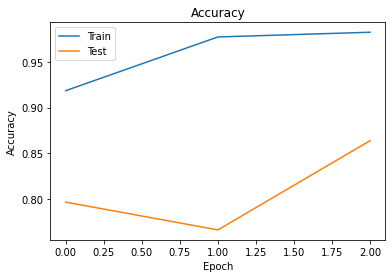

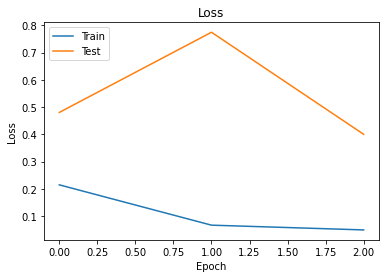

In [0]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

Save the model

In [0]:
modelv5.save("/content/gdrive/My Drive/pneumonia/VGG16.h5")

We have 16 images in validation, as we see its nearly predict some images, and 
gives an understanding about the remaining images


In [0]:
model = models.load_model("/content/gdrive/My Drive/pneumonia/models/VGG16.h5")
predictions = model.predict(imagesTest)
predictions = predictions.reshape(1, -1)[0]

x = 0
y = []

for i in range(0, len(predictions), 2):
  if predictions[i] > predictions[i + 1]:
    if dset["labelsTest"][i / 2] == 0:
      x += 1
      y.append(predictions[i])
    else: 
      y.append(predictions[i + 1])  

  if predictions[i] < predictions[i + 1]:
    if dset["labelsTest"][i / 2] == 1:
      x += 1  
      y.append(predictions[i + 1])
    else: 
      y.append(predictions[i])

print(x / len(imagesTest))
print(np.sum(y) / len(y))

# inceptionV3Fromh5Dataset
# 0.8076923076923077
# 0.8013032766488882

# inceptionv3
# 0.6314102564102564
# 0.6281051635742188

# VGG16
# 0.8253205128205128
# 0.8053299830510066

# InceptionResNetV2
# 0.8237179487179487
# 0.803289071107522

# ResNet152V2
# 0.8012820512820513
# 0.7945780631823417

# MobileNetV2
# 0.8637820512820513
# 0.8522662627391326

# ????
# xception
# 0.5608974358974359
# 0.5300631400866386

# ????
# DenseNet201
# 0.5608974358974359
# 0.5300631400866386

In [0]:
# def barplot(x_data, y_data, x_label="", y_label="", title=""):
#     _, ax = plt.subplots()
#     # Draw bars, position them in the center of the tick mark on the x-axis
#     ax.bar(x_data, y_data, color = '#539caf', align = 'center')
#     # Draw error bars to show standard deviation, set ls to 'none'
#     # to remove line between points
#     #ax.errorbar(x_data, y_data, yerr = error_data, color = '#297083', ls = 'none', lw = 2, capthick = 2)
#     ax.set_ylabel(y_label)
#     ax.set_xlabel(x_label)
#     ax.set_title(title)   

In [0]:
def global_test(dir_models, dir_test_image):

    models_stat = []
    num_mod = 0

    labels = []
    images = []

    for nextDirectory in os.listdir(dir_test_image):
        if not nextDirectory.startswith("."):
            if nextDirectory in "NORMAL":
                label = 0
            elif nextDirectory in "PNEUMONIA":
                label = 1
            else:
                label = 2

            currentDirectory = dir_test_image + nextDirectory
            if not currentDirectory.startswith("."):
                for files in os.listdir(currentDirectory):
                    if files.endswith('.jpg') or files.endswith('.jpeg'):
                        imagePath = currentDirectory + "/" + files
                        img = Image.open(imagePath)
                        img = img.resize((size, size)).convert("RGB")
                        data = np.array(img.getdata())
                        img = 2 * (data.reshape((img.size[0], img.size[1], 3)).astype(np.float32) / 255) - 1
                        images.append(img)
                        labels.append(label)

    labels = np.asarray(labels)
    average_accuracy = [0] * len(labels)

    out = h5py.File("/content/gdrive/My Drive/pneumonia/tmptest.h5", "a")
    out.create_dataset("imagesTmp", data=images)
    out.close()

    dset = h5py.File("/content/gdrive/My Drive/pneumonia/tmptest.h5", "r")
    imagesTmp = dset["imagesTmp"][:]
    os.remove("/content/gdrive/My Drive/pneumonia/tmptest.h5")

    for file_model in os.listdir(dir_models):
        num_mod += 1

        dir_model = dir_models + "/" + file_model
        name = file_model[:-3]
        model_stat = [name]
    
        model = models.load_model(dir_model)
        predictions = model.predict(imagesTmp)
        predictions = predictions.reshape(1, -1)[0]

        accuracy_array = []

        x = -1
        for i in range(0, len(predictions), 2):
            x += 1  
            if predictions[i] > predictions[i + 1]:
                if labels[x] == 0:
                   accuracy_array.append(predictions[i])
                   average_accuracy[x] += predictions[i]
                else: 
                   accuracy_array.append(predictions[i + 1])  
                   average_accuracy[x] += predictions[i + 1]

            if predictions[i] < predictions[i + 1]:
               if labels[x] == 1:
                 accuracy_array.append(predictions[i + 1])
                 average_accuracy[x] += predictions[i + 1]
               else: 
                  accuracy_array.append(predictions[i])
                  average_accuracy[x] += predictions[i]

        model_stat.append(np.sum(accuracy_array) / len(accuracy_array) * 100)
        models_stat.append(model_stat)
        # print(model_stat)
    for i in range(len(average_accuracy)):
        average_accuracy[i] = average_accuracy[i] / num_mod
    models_stat.append(["Average", np.sum(average_accuracy) / len(average_accuracy) * 100])
    # print(["Average", np.sum(average_accuracy) / len(average_accuracy) * 100])

    x_data = []
    y_data = []
    for i in range(len(models_stat)): 
        x_data.append(models_stat[i][0])
        y_data.append(models_stat[i][1])
    _, ax = plt.subplots()
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Models") 

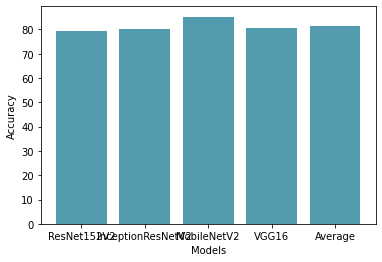

In [17]:
global_test("/content/gdrive/My Drive/pneumonia/models", "/content/gdrive/My Drive/pneumonia/test/")

In [0]:
def global_predict(dir_models, dir_image):

    images_stat = []
    num_mod = 0

    name_image = []
    images = []

    for files in os.listdir(dir_image):
        if files.endswith('.jpg') or files.endswith('.jpeg'):
            imagePath = dir_image + files
            name_image.append(files)
            img = Image.open(imagePath)
            img = img.resize((size, size)).convert("RGB")
            data = np.array(img.getdata())
            img = 2 * (data.reshape((img.size[0], img.size[1], 3)).astype(np.float32) / 255) - 1
            images.append(img)

    out = h5py.File("/content/gdrive/My Drive/pneumonia/tmptest.h5", "a")
    out.create_dataset("imagesTmp", data=images)
    out.close()

    dset = h5py.File("/content/gdrive/My Drive/pneumonia/tmptest.h5", "r")
    imagesTmp = dset["imagesTmp"][:]
    os.remove("/content/gdrive/My Drive/pneumonia/tmptest.h5")

    for file_model in os.listdir(dir_models):
        num_mod += 1
        dir_model = dir_models + "/" + file_model
    
        model = models.load_model(dir_model)
        predictions = model.predict(imagesTmp)
        predictions = predictions.reshape(1, -1)[0]

        accuracy_array = []

        for i in range(0, len(predictions), 2):
            accuracy_array.append(predictions[i + 1])
        images_stat.append(accuracy_array)

    result = []    

    for i in range(len(name_image)):
        sum_ac = 0
        for j in range(num_mod):
            sum_ac += images_stat[j][i]  
        result.append([name_image[i], sum_ac / num_mod * 100])
    print(result)



In [13]:
global_predict("/content/gdrive/My Drive/pneumonia/models", "/content/gdrive/My Drive/pneumonia/predict/")

ResNet152V2.h5
InceptionResNetV2.h5
MobileNetV2.h5
VGG16.h5
[['IM-0001-0001.jpeg', 55.00258356332779], ['IM-0003-0001.jpeg', 26.053437404334545], ['IM-0005-0001.jpeg', 22.019844129681587], ['IM-0006-0001.jpeg', 50.540392100811005], ['IM-0007-0001.jpeg', 11.923751328140497], ['person1_virus_6.jpeg', 99.8673141002655], ['person1_virus_7.jpeg', 99.90636706352234], ['person1_virus_8.jpeg', 99.96706992387772], ['person1_virus_9.jpeg', 99.97649192810059], ['person1_virus_11.jpeg', 99.9805137515068], ['person1_virus_12.jpeg', 99.89671260118484]]
